<img style="float: left;padding: 1.3em" src="https://raw.githubusercontent.com/gw-odw/odw-2022/main/Tutorials/logo.png">  

#  Gravitational Wave Open Data Workshop #5


#### Tutorial 3.3:  Population Inference with Gravitational Wave Data

In this tutorial, we will discuss the background and implementation of hierarchical/population inference, both generically and as applied to GW analyses. This tutorial will use the Python package `GWPopulation` which can be accessed at: https://github.com/ColmTalbot/gwpopulation/ and the associated docs are at https://colmtalbot.github.io/gwpopulation/. 


#Installation (execute only if running on a cloud platform!)

In [3]:
# -- Use the following line in Google Colab
#!pip install gwpopulation==0.6.3 nestle==0.2.0

  Using cached gwpopulation-0.6.3.tar.gz (18 kB)
     |████████████████████████████████| 2.2 MB 5.3 MB/s 
     |████████████████████████████████| 86 kB 5.4 MB/s 
     |████████████████████████████████| 46 kB 2.1 MB/s 
     |████████████████████████████████| 38.1 MB 1.4 MB/s 
  Created wheel for gwpopulation: filename=gwpopulation-0.6.3-py3-none-any.whl size=20680 sha256=cdd080d7db7633c5c40f1e413802a0e5f9bd13fcb92b7d6569454eb9e0eab57f
  Stored in directory: /root/.cache/pip/wheels/ff/92/9b/ca6c3148c2355ab7b6de2468d6ab3090ba1dc71d52eaa46294
  Created wheel for nestle: filename=nestle-0.2.0-py3-none-any.whl size=12457 sha256=fa2da47b24d3e73f1caa18a213387c1f20ad694a68987a58eeeefc98b2ecdd7f
  Stored in directory: /root/.cache/pip/wheels/12/96/d9/fb8f0e7ed8164becad7d76d8a94909497a984d2bebe9efec74
  Created wheel for bilby: filename=bilby-1.1.5-py3-none-any.whl size=2250290 sha256=163c5adc7ec8da26d4faa5c763522f9748b7756e7b8e1337b4797f2d211efaf9
  Stored in directory: /root/.cache/pip/wheels/d

#A Hierarchy of Bayesian Inference



As we saw in previous exercises, to determine the masses, spins, and distances to each event the LVK observes, we obtain distributions for these parameters using Bayesian parameter estimation. When we do parameter estimation for each of the LVK's events, we begin by taking our strain data and we sample the physical parameters that may have generated the data we see. By using a likelihood model for the data given these parameters and a prior on the parameters, we obtain a distribution of the physical parameters for an event.

Hierarchical Bayesian inference can be thought of as the method we use to constrain the parameters that exist one "layer" above our single-event inference. Given the distribution of physical parameters that we recover from all events in our catalog, what does this say about the population of *all* sources out in the universe? In other words, what is the *astrophysical* distribution that generated the events we recorded?

The bottom layer of this hierarchy is the individual events from the population that we obtain data for. This part was covered in the previous Parameter Estimation tutorials. In the case of LVK observations, this includes the masses, spins, redshifts we have recovered for each event. It is the job of the Parameter Estimation analyses to obtain a set of posterior samples for these parameters for each event individually. 

Recall that for each event, Bayes theorem says:

$p(\theta|d) \propto \mathcal{L}(d|\theta) \pi(\theta)$,

for some set of parameters $\theta$ (e.g. $\theta = (m_1, m_2, z))$ and strain data d.

Typically, we obtain samples for $\theta$ by using a Gaussian likelihood model for $\mathcal{L}$ and sampling with either a Markov Chain Monte Carlo (MCMC) or nested sampler. We use these sampling methods because the above equation usually involves several dimensions and cannot be integrated analytically. For the purposes of population inference, we can assume we already have samples from the posterior distribution for each event in our catalog. Typically LVK parameter estimation gives $\mathcal{O}(10,000)$ samples of $\theta$ for each event. Using these samples, we use hierarchical inference to constrain the parameters of the population model that represents the astrophysical distribution of GW sources.


In this example, $\textbf{$\theta$}_i$, our physical parameters for each BBH merger event, consists of the set of posterior samples for the $i^{th}$ BBH event. Recall that the samples for $\theta_i$ we get from parameter estimation for each event are technically from the $posterior$ distributions, which is just the likelihood times the prior. For this example, we will pretend that the draws from the posterior are actually draws from the likelihood. This assumption is of course incorrect, but we will do this for simplicity.

We now assume a population model $p(\theta_i|\Lambda)$, a probability distribution for the physical parameters we measure with gravitational waves, parameterized by $\Lambda$. Our goal now is to use the physical parameters we inferred for each event to infer the values of the $hyper$parameters $\Lambda$ characterizing the population.

When we assume that each of N events are independent draws from the population, we express the likelihood of the observed data given some population-level hyperparameters $\Lambda$ as:

$\mathcal{L}(d|\Lambda) = \prod\limits_{i}^{N} \int d\theta_i \mathcal{L}(d_i|\theta_i) p(\theta_i|\Lambda)$


The reason we have the single-event likelihood multiplied by the population probability in the integrand is because we are evaluating the probability of the true $\theta$ of the $i$th event being $\theta_i$ *and* the population model generating $\theta_i$. Since we know how much support the likelihood gives for any $\theta_i$ being the true parameter value, we integrate over all possible $\theta_i$ values. We then take the product over the N events since we are calculating this probability for all of the observed events.

All in all, what this equation is telling us is what is the likelihood of observing the data we record given some distribution of physical parameters describing the population. In practice, we compute the integral above via Monte Carlo summation, drawing $M$ single-event samples for $\theta_i$ for each event. So we compute the above likelihood as:

$\mathcal{L}(d|\Lambda) = \prod\limits_{i}^{N} \frac{1}{M}\sum\limits_{\theta_i \sim \mathcal{L}(d_i|\theta_i)} p(\theta_i|\Lambda)$.


For this example, let us consider the masses of the sources in O3b and try to infer the corresponding mass distribution.

In [6]:
import gwpopulation
import numpy as np
import bilby
import matplotlib.pyplot as plt
import h5py
import pandas as pd

#Reading in the O3b Data



The posterior samples for the masses of each event are stored in HDF5 files in the Parameter Estimation data release (which can be found [here](https://zenodo.org/record/5546663#.YjIy1fXMIdA)). Here we will consider the O3b BBH events with a FAR < 1/yr. For the purposes of storage space, we have downsampled the hdf5 files and put them on [this link](https://dcc.ligo.org/LIGO-T2200137) on LIGO's Document Control Center.

If you were doing this for a real scientific study, you would download the full parameter estimation data from the Zenodo link rather than use pre-downsampled data. 

Let's find the files and list them. 

In [5]:
!wget -O downsampled.tar.gz "https://dcc.ligo.org/public/0182/T2200137/001/O3bPE_downsampled.tar.gz"
!tar -xvzf downsampled.tar.gz
import glob
files = glob.glob('*.h5')

--2022-05-23 15:50:53--  https://dcc.ligo.org/public/0182/T2200137/001/O3bPE_downsampled.tar.gz
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106436912 (102M) [application/x-gzip]
Saving to: ‘downsampled.tar.gz’

downsampled.tar.gz  100%[===================>] 101.51M  28.3MB/s    in 3.8s    

2022-05-23 15:50:57 (27.0 MB/s) - ‘downsampled.tar.gz’ saved [106436912/106436912]

./S191103a.h5
./S191105e.h5
./S191109d.h5
./S191127p.h5
./S191129u.h5
./S191204r.h5
./S191215w.h5
./S191216ap.h5
./S191222n.h5
./S191230an.h5
./S200105ae.h5
./S200112r.h5
./S200115j.h5
./S200128d.h5
./S200129m.h5
./S200202ac.h5
./S200208q.h5
./S200209ab.h5
./S200216br.h5
./S200219ac.h5
./S200224ca.h5
./S200225q.h5
./S200302c.h5
./S200311bg.h5
./S200316bj.h5


['S200224ca.h5',
 'S200202ac.h5',
 'S191129u.h5',
 'S200112r.h5',
 'S200302c.h5',
 'S191127p.h5',
 'S200208q.h5',
 'S200219ac.h5',
 'S200128d.h5',
 'S191105e.h5',
 'S200209ab.h5',
 'S191109d.h5',
 'S191103a.h5',
 'S200225q.h5',
 'S191230an.h5',
 'S200316bj.h5',
 'S191216ap.h5',
 'S191204r.h5',
 'S200105ae.h5',
 'S191222n.h5',
 'S200216br.h5',
 'S200129m.h5',
 'S200115j.h5',
 'S191215w.h5',
 'S200311bg.h5']

Now we can pull in our data to fill in the "bottom layer" of the hierarchy. As noted above, we are interested in the masses, specifically the mass ratio and primary mass distributions. `GWPopulation` expects our samples to be in a list of `pandas` DataFrames, where each element of the list is a dictionary consisting of samples for $\theta$ for a particular event. So lets construct our dataset as such. Each dataframe has columns keyworded by the name of the parameter.
What we are doing here is reading in the posterior samples for source frame primary mass and mass ratio for each event in O3b. We read in the samples stored in the field "C01:Mixed" as this refers to the posterior samples that are mixed between IMRPhenomXPHM and SEOBNRv4PHM waveform models.

Note we are also skipping the NSBH events as they are not part of the BBH population. 

In [7]:
posteriors = []
for file in files:
    if '200105' in file or '200115' in file:
        continue
    with h5py.File(file, 'r') as eventfile:
        post = pd.DataFrame()
        samples = eventfile['C01:Mixed']['posterior_samples']
        post['mass_ratio'] = samples['mass_ratio']
        post['mass_1'] = samples['mass_1_source']
        posteriors.append(post)


#Defining the Population Model



Astronomers tell us that the Initial Mass Function (IMF) of stars can generally be modelled as a powerlaw. We therefore use this as motivation for the following truncated power law parameterization of the BBH mass distribution:

$p(m_1|\alpha, M_\min, M_\max) \propto \begin{cases} m_1 ^ {-\alpha} & \text{$M_\min$ < $m_1$ < $M_\max$} \\ 0 & \text{otherwise}\end{cases}$

Our goal here will be to infer the value of the power law index $\alpha$ and the minimum and maximum primary masses in the population, $M_\min$ and $M_\max$, respectively. We will also model the mass ratio distribution according to a powerlaw with a different index:

$p(q|\beta, M_\min, m_1) \propto \begin{cases}
q ^ {\beta} & \text{if $M_\min$ < $m_2$ < $m_1$} \\ 
0 & \text{otherwise}
\end{cases}$


$\theta$ now consists of the primary mass and mass ratio samples for each event, and our hyperparameters are $\Lambda = (\alpha, \beta, M_\max, M_\min)$. We express our population model likelihood as $p(\theta|\Lambda)$ = $p(m_1, q|\alpha, \beta, M_\max, M_\min)$

This particularly simple 4-hyperparameter population model for the masses is already included in the `GWPopulation` package, where it can be accessed as `gwpopulation.models.mass.power_law_primary_mass_ratio`. `GWPopulation` also includes functions for several other mass distributions we use in the LVK populations papers, but those are beyond the scope of this tutorial.

A note of notation: Since the population likelihood defined above is specifically in terms of a powerlaw population model, we denoted the population model probability as $p(\theta|\alpha, \beta, M_\max, M_\min)$. We are of course not limited to a powerlaw population, so in general you may see the population model expressed as $p(\theta|\Lambda)$ where $\Lambda$ is the set of population hyperparameters. For example, if you want to model a population as a normal distribution, then $\Lambda$ would consist of the mean and standard deviation.

In [8]:
population = gwpopulation.models.mass.power_law_primary_mass_ratio

#Selection Effects Term



The last thing we must consider in the likelihood is the effect that observational bias plays in recovering the astrophysical distribution. Our goal is to use the events we observe to infer the astrophysical distribution of BBH masses in the universe, so we must account for the relative probability of detecting high mass events vs low mass events and incorporate this into our likelihood. Specifically, since (generally!) high-mass mergers are more detectible than low-mass mergers, we must penalize the likelihoods of populations that predict too many high-mass (i.e. more-detectable) events. 

This is typically implemented by altering the likelihood as such:

$\mathcal{L}(d|\Lambda) \propto p_\textrm{det}(\Lambda)^{-N} \prod\limits_{i}^{N} \int d\theta_i \mathcal{L}(d_i|\theta_i) p(\theta_i|\Lambda)$

where $p_\textrm{det}(\Lambda)$ is this "detection probability" term to incorporate selection effects. 

We compute this term as:

$p_\textrm{det}(\Lambda) = \int p(\theta|\Lambda) p_\textrm{det}(\theta) d\theta$

As a very simple model, we assume that the detectible volume scales as $\mathcal{M}^{5/2}$. 



Thus we are making the assumption $p_\textrm{det}(\mathcal{M}) \propto \mathcal{M}^{5/2}$

Note that is a very simplified for the selection effects. Typically, we use injection campaigns where we empirically determine the efficiency of detecting events across parameter space. Additionally, we usually must consider the effects of spins and distances in the selection effects term. For the purposes of this tutorial we just use a simple scaling heuristic and recover reasonable results. 


In [9]:
m1 = np.linspace(3.1, 60, 100)
q = np.linspace(0.05, 1, 100)
m1_grid, q_grid = np.meshgrid(m1, q)
chirps = bilby.gw.conversion.component_masses_to_chirp_mass(m1_grid, m1_grid * q_grid)
vt_selection = chirps**(5/2)

mass_grid = dict()
mass_grid['mass_1'] = m1_grid
mass_grid['mass_ratio'] = q_grid

def p_det(params):
    p_m = gwpopulation.models.mass.power_law_primary_mass_ratio(mass_grid, **params)
    
    return np.trapz(np.trapz(p_m * vt_selection, q, axis = 0), m1, axis=0)

#Setting Up the Run



That's it! We are ready to set up our likelihood and place our constraints on our hyperparameters $\Lambda = (\alpha, \beta, M_\max, M_\min)$. `GWPopulation` has a class `HyperParameterLikelihood` that does the computation for the likelihood as defined above. In the notation of `GWPopulation`, the population model is the `hyper_prior` since it acts as a hyperparameter-dependent prior, multiplying the single-event likelihoods. The `HyperparameterLikelihood` class knows how to incorporate the selection effects term, so we are ready to set up our likelihood as such.

In [10]:
likelihood = gwpopulation.hyperpe.HyperparameterLikelihood(posteriors = posteriors, hyper_prior = population, selection_function = p_det)

15:57 bilby WARNING : Cannot import cupy, falling back to numpy.
15:57 bilby INFO    : No prior values provided, defaulting to 1.


Note that there will be warnings. The warning for not importing cupy is just telling us we are running on a CPU and not a GPU.
The second warning refers to the fact that we are not dividing out a prior for each single-event sample, and are thus treating samples from the single-event posteriors as if they were samples drawn from the likelihood. This is incorrect treatment, but an approximation we make for simplicity in this tutorial.

Our last step is now to define some priors for the population hyperparameters. Again, we will assume uniform priors, and set them to be relatively narrow for sampling efficiency:

In [11]:
from bilby.core.prior import PriorDict, Uniform

priors = PriorDict(
    dict(
    alpha = Uniform(minimum=0, maximum=4, latex_label='$\\alpha$'),
    beta = Uniform(minimum=0, maximum=7, name='beta', latex_label='$\\beta_{q}$'),
    mmax = Uniform(minimum=30, maximum=60, name='mmax', latex_label='$m_{\\max}$'),
    mmin = Uniform(minimum=3, maximum=12, name='mmin', latex_label='$m_{\\min}$'),
))

#Running the Sampler



And now we have all we need to run the sampler! 
Now we are ready to sample our (hyper)-posterior. For this, we will use `bilby`'s wrapper for `nestle`, a nested sampler with which we use simplified settings to run quickly in the cell.

The `run_sampler` method in `bilby` provides several useful features including checkpointing runs and automatic saving of a result file at completion. When running in a notebook or terminal, you may also see real-time updates of the status of the sampler. The final result file is saved in the location specified by the `outdir` argument and with the `label` argument. By default, this will save a json file containing the priors, resulting posterior samples, and meta data from the run, as well as useful built-in methods such as making corner plots of the posterior distribution.

You can safely ignore the warnings that it gives. We will run with very lenient settings so we can sample quickly. This next cell will take about 5 minutes or so. 

In [12]:
bilby.run_sampler(likelihood = likelihood, priors = priors, label = 'O3b', use_ratio=True, resume=False, outdir = './O3b_result', sampler='nestle')

15:59 bilby INFO    : Running for label 'O3b', output will be saved to './O3b_result'
15:59 bilby INFO    : Search parameters:
15:59 bilby INFO    :   alpha = Uniform(minimum=0, maximum=4, name=None, latex_label='$\\alpha$', unit=None, boundary=None)
15:59 bilby INFO    :   beta = Uniform(minimum=0, maximum=7, name='beta', latex_label='$\\beta_{q}$', unit=None, boundary=None)
15:59 bilby INFO    :   mmax = Uniform(minimum=30, maximum=60, name='mmax', latex_label='$m_{\\max}$', unit=None, boundary=None)
15:59 bilby INFO    :   mmin = Uniform(minimum=3, maximum=12, name='mmin', latex_label='$m_{\\min}$', unit=None, boundary=None)
/usr/local/lib/python3.7/dist-packages/gwpopulation/hyperpe.py:125: RuntimeWarning: divide by zero encountered in log
  xp.sum(self.hyper_prior.prob(self.data) / self.sampling_prior, axis=-1)
15:59 bilby INFO    : Single likelihood evaluation took 3.319e-02 s
15:59 bilby WARNING : Supplied argument 'npool' not an argument of 'Nestle', removing.
15:59 bilby WARNI

it=  3012 logz=-250.254887


16:04 bilby INFO    : Sampling time: 0:04:34.004589
16:04 bilby INFO    : Summary of results:
nsamples: 3513
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.085
ln_bayes_factor: -249.935 +/-  0.085



#Viewing Our Results



**Wait for the above cell to finish running before moving on**

Now we can use bilby to read in the result file and make a corner plot to see our inferred posterior distribution. 

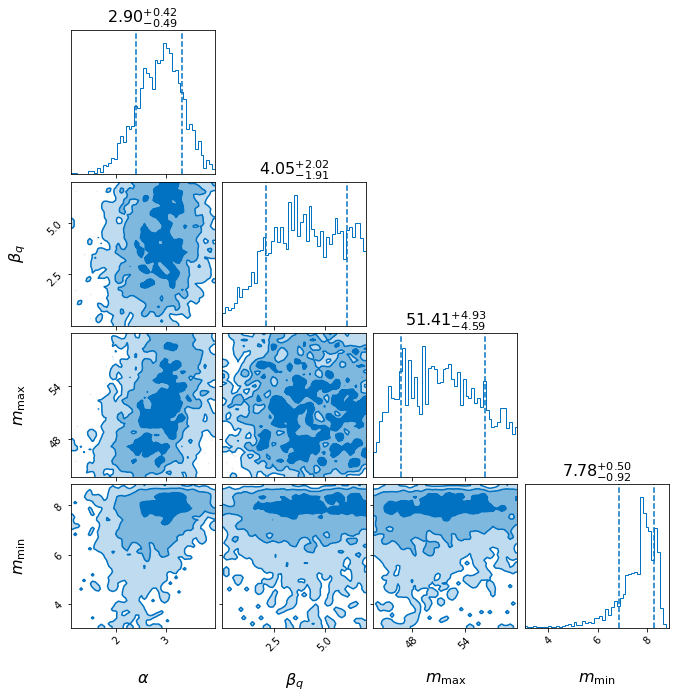

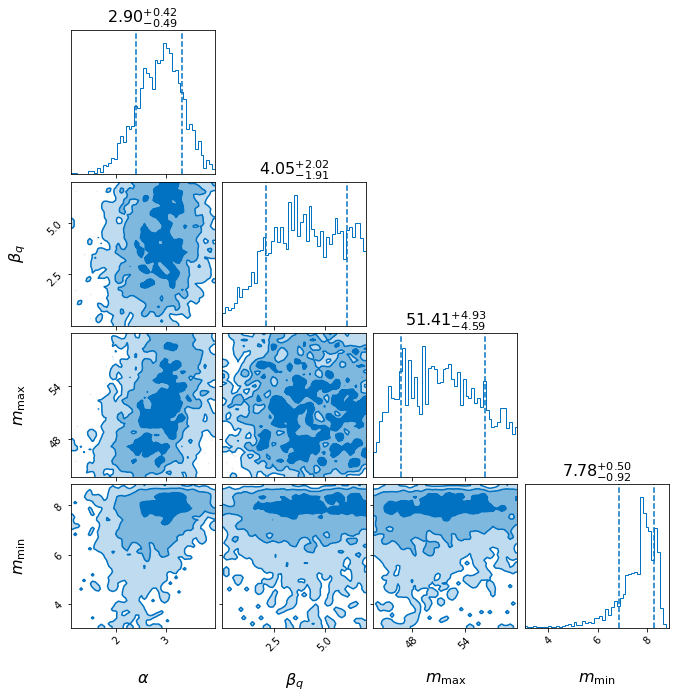

In [13]:
%matplotlib inline
result = bilby.result.read_in_result('./O3b_result/O3b_result.json')
result.plot_corner(save=False)

Note that these results will differ from those of full population analyses due to the simplifications we made along the way. While this is just a simple toy model, this demonstrates how you may prepare `GWPopulation` analyses and view the results.

Note that the plot_corner() command both plotted the corner plot inline and can save a copy in the directory you save your result file. 

We can also now look at our inferred distribution for $m_1$. Let's plot the inferred 90% credible intervals.

In [14]:
m1s = np.linspace(2,70, 1000)
qs = np.linspace(0,1,1000)

mlines = []
samples = result.posterior.sample(1000)
for ii in range(len(samples)):
  sample = samples.iloc[ii]
  m1probs = gwpopulation.utils.powerlaw(m1s, alpha = -sample['alpha'], high=sample['mmax'], low=sample['mmin'])
  mlines.append(m1probs)
mlines = np.array(mlines)

Text(0.5, 0, '$m_1$')

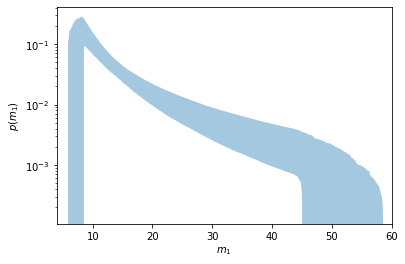

In [15]:
plt.fill_between(m1s, np.percentile(mlines, 5, axis=0), np.percentile(mlines, 95, axis=0), alpha = 0.4)
plt.xlim(4,60)
plt.yscale('log')
plt.ylabel(r'$p(m_1)$')
plt.xlabel(r'$m_1$')

#Words of Wisdom



This tutorial was intended to demonstrate the basics of population inference and how to use `GWPopulation` to infer population properties from GW observations. Several aspects of using population inference with GW events were left out or simplified for this tutorial. These aspects include:

- A complete population model: The population models we use in LVK population analyses typically characterize mass, spin, and redshift distributions. Some of the hyperparameters of these distribution exhibit nontrivial correlations, so it is important to do to include them all in the population model. Furthermore, we know now that a simple truncated power law is insufficient to provide the best fit to the mass distribution; we therefore use more complicated mass distributions that allow for more features such as peaks and power law breaks. Additionally, the mass distributions we use typically include a "smooth turn-on" at low masses so the mass distribution does not begin right at the peak of the power law.

- Jacobians: If the events are not sampled in terms of the same exact physical parameters characterized by the population model, a jacobian is necessary to transform the probability distribution correctly. For example, LVK parameter estimation imposes priors on the detector-frame masses, whereas our population model characterizes the source-frame primary mass and the mass ratio distributions. The conversion between these parameters must be taken into account to do population inference correctly.

- Sensitivity Estimation: As noted above, a true population inference study must accurately account for the detection probability of a population in terms of the population parameters. This usually involves computing an empirically-derived or semi-analytic approximation to the detection probability for each sample of $\Lambda$. See Appendix A in the [GWTC-3 Populations Paper](https://dcc.ligo.org/DocDB/0177/P2100239/011/o3_population.pdf) for more details on how this is handled in LVK analyses.

- Single-event priors: While we reweighted samples from the *posterior* distribution into our population model, the equations above are expressed in terms of reweighting samples from the *likelihood* distribution. Therefore, if there are nontrivial priors imposed on the single-event posteriors, those must be divided out to convert the posterior samples to likelihood samples.

- Speed: When working with $\mathcal{O}(10-100)$ events each with $\mathcal{O}(10,000)$ posterior samples, computing the likelihoods for population inference can be *slow*. Fortunately, as the the likelihood involves mainly array broadcasting and matrix manipulations, this can usually be significantly sped up by computing on a GPU. `GWPopulation` can handle this by setting an argument `cupy = True` in the HyperparameterLikelihood class. You just need to make sure your population model and selection function are using cupy and GPU-friendly operations as well. A lot of times you can simply use cupy functions as drop-ins for numpy functions. We find that this can substantially reduce the computation time for hierarchical inference problems. 

- Sampling: Typically you should play with the sampler settings and convergence criteria to be optimal for your particular problem. With `dynesty` we typically increase the `nact` argument to make sure the final output is better-converged. We also can increase the `nlive` argument to use more "live points" the sampler uses. There are various settings to change, and you can read more about sampling with `Bilby`'s implementations in [Bilby's docs](https://lscsoft.docs.ligo.org/bilby/samplers.html#nested-samplers) and links therein.

- A complete catalog: We might as well use all the data we can! Of course, we have access to data not just from O3b, but also O1, O2, and O3a. A complete catalog of sources (using, say, 70 events rather than ~30) will inform our population inference much more. We only used O3b events in this tutorial for simplicity.

#Challenge Questions

If we had included GW190814, an O3a event with $m_1 = 23 M_\odot$ and $m_2 = 2.6 M_\odot$, how would the inferred value of $m_\min$ change? If in O4 we detect relatively more than expected low-mass black holes, how would this affect the inferred value for $\alpha$?

#Further Reading



If you've made it this far, you may be interested in reading further details about implementations of population inference for GW studies. I recommend:

- [LIGO, Virgo, KAGRA collaboration 2021](https://arxiv.org/abs/2111.03634): Collaboration paper analyzing the population of compact binary mergers in GWTC-3. See the methods section for details on the models and codes used in this work.

- [Thrane & Talbot 2018](https://arxiv.org/abs/1809.02293): Contains an overview of Bayesian inference as applied to GW analyses, as well as mathematical and conceptual background of population inference. Appendices contain many formulae that users may find useful. 

- [GWPopulation_pipe](https://docs.ligo.org/RatesAndPopulations/gwpopulation_pipe/): This is the pipeline we use to actually run population analyses using GWPopulation. This pipeline conveniently wraps the various population models, sampling, and conversion routines and outputs for a full LVK population analysis run. 

- If you are interesting in learning how to view and interpret the outputs of the GWPopulation analyses for the GWTC-3 Astrophysical Distributions paper, I encourage you to download the correpsonding data release from [this Zenodo page](https://zenodo.org/record/5655785#.YjN98_XMKAk) and check out the "tutorials" subdirectory.